<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/02-contextbanits_tutorial_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q tf-agents

     |████████████████████████████████| 1.2MB 5.8MB/s 


In [ ]:
import numpy as np
import tensorflow as tf

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

import matplotlib.pyplot as plt

In [ ]:
def context_sampling_fn(batch_size):
  """Contexts from [-10, 10]^4."""
  def _context_sampling_fn():
    return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
  return _context_sampling_fn


class LinearNormalReward(object):
  """A class that acts as linear reward function when called."""
  
  def __init__(self, theta, sigma):
    self.theta = theta
    self.sigma = sigma
  
  def __call__(self, x):
    mu = np.dot(x, self.theta)
    return np.random.normal(mu, self.sigma)

In [ ]:
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param

arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))

In [ ]:
action = [0, 1] #@param
print('Reward:', environment.step(
    tf.cast(action, dtype=tf.int32)).reward.numpy())

Reward: [ 28.805355 -26.814754]


In [ ]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

In [ ]:
observation = context_sampling_fn(batch_size)()
print(f'observation:\n{observation}')
time_step = ts.restart(observation)
print(f'action={agent.collect_policy.action(time_step).action}')

observation:
[[ 7. -7. -8.  0.]
 [ 5.  4. -6. -9.]]
action=[0 0]


In [ ]:
def compute_optimal_reward(observation):
  expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
  optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
  
  return optimal_action_reward

regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)


[[[ 4.  3.  2.  5.]]

 [[ 4. -4. -1. -9.]]] -
 [[7.]
 [9.]] -
 [[7.496811]
 [8.000291]]
[[[  4.   7.  -4.  -8.]]

 [[ -7. -10.   1.   5.]]] -
 [[ 0.]
 [16.]] -
 [[ 0.5108589]
 [16.307806 ]]
[[[ 8.  6.  6.  5.]]

 [[-9.  1.  6. -7.]]] -
 [[14.]
 [47.]] -
 [[16.107502]
 [46.415745]]
[[[-4.  7. -1. -5.]]

 [[ 7.  3.  7. -9.]]] -
 [[21.]
 [22.]] -
 [[21.744202]
 [22.201948]]
[[[-10.  -9.  -3.  -2.]]

 [[ -2.  -4.   9.  -1.]]] -
 [[31.]
 [33.]] -
 [[31.271284]
 [33.574097]]
[[[ 3.  4.  9.  0.]]

 [[ 7. -1.  0.  5.]]] -
 [[22.]
 [ 9.]] -
 [[22.181894]
 [ 8.796545]]
[[[-4. -5. -4.  0.]]

 [[-2.  4. -3.  3.]]] -
 [[8.]
 [0.]] -
 [[ 8.99328  ]
 [-0.7226153]]
[[[  1.   8.   3. -10.]]

 [[-10.  -9.  -9.  -7.]]] -
 [[20.]
 [35.]] -
 [[19.61197 ]
 [34.719215]]
[[[ 5. -3. -6.  4.]]

 [[ 4. -8. -4. -3.]]] -
 [[-2.]
 [ 8.]] -
 [[-2.6776664]
 [ 7.469348 ]]
[[[ 8.  1.  6.  6.]]

 [[ 8.  8. -3. -9.]]] -
 [[24.]
 [-9.]] -
 [[22.638556 ]
 [-7.7667413]]
[[[ -4. -10.  -4.  -7.]]

 [[  6.   6.   1.  -1.]]] -


Text(0.5, 0, 'Number of Iterations')

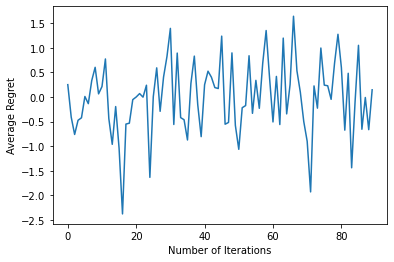

In [ ]:
num_iterations = 90 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  experience = replay_buffer.gather_all()

  print(
      experience.observation.numpy(), '-\n', 
      compute_optimal_reward(experience.observation).numpy(), '-\n',
      experience.reward.numpy())

  loss_info = agent.train(experience)
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')
